In [2]:
%pip install matplotlib


     ---------------------------------------- 0.0/167.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/167.0 kB ? eta -:--:--
     ------ ------------------------------ 30.7/167.0 kB 435.7 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/167.0 kB 435.7 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/167.0 kB 435.7 kB/s eta 0:00:01
     --------- --------------------------- 41.0/167.0 kB 140.3 kB/s eta 0:00:01
     --------------- --------------------- 71.7/167.0 kB 218.6 kB/s eta 0:00:01
     ------------------------ ----------- 112.6/167.0 kB 297.7 kB/s eta 0:00:01
     ------------------------ ----------- 112.6/167.0 kB 297.7 kB/s eta 0:00:01
     ------------------------------ ----- 143.4/167.0 kB 275.0 kB/s eta 0:00:01
     ------------------------------------ 167.0/167.0 kB 295.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.8 MB 1.7 MB/s


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [3]:
%pip install pathlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from pathlib import Path

In [5]:
# Define paths to train and test directories
TRAIN_DIR = Path("data/train")
TEST_DIR = Path("data/test")

In [6]:
# Data Augmentation for the training set and rescaling for both train and test sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for the training set to avoid overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# No augmentation for the test set, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Load images from train and test folders
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Validation for test set
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 2856 images belonging to 87 classes.
Found 363 images belonging to 87 classes.
Found 0 images belonging to 87 classes.


In [11]:
# Create the convlution base
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,144 (367.75 KB)

 Trainable params: 93,696 (366.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Add dense layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(87, activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 87)             │        11,223 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,840,471 (18.46 MB)

 Trainable params: 4,840,023 (18.46 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
# Model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Model training using test_generator for validation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,  # Using test set for validation
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=25)


Epoch 1/25


c:\Users\DELL\Desktop\DL-Assignment-Y4S1\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.0143 - loss: 6.6899 - val_accuracy: 0.0114 - val_loss: 25.8561
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0312 - loss: 4.3764 - val_accuracy: 0.0000e+00 - val_loss: 29.7870
Epoch 3/25


C:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


89/89 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.0215 - loss: 4.6547 - val_accuracy: 0.0170 - val_loss: 21.2539
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0625 - loss: 4.1895 - val_accuracy: 0.0000e+00 - val_loss: 31.2457
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.0167 - loss: 4.5902 - val_accuracy: 0.0170 - val_loss: 6.2618
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0312 - loss: 4.3002 - val_accuracy: 0.0000e+00 - val_loss: 6.0190
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.0228 - loss: 4.4810 - val_accuracy: 0.0312 - val_loss: 4.9232
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 4.9091 - val_accuracy: 0.0000e+00 - val_loss: 4.6955
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.0360 - loss: 4.4343 - val_accuracy: 0.0284 - val_loss: 4.4906
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 4.4107 - val_accuracy: 0.

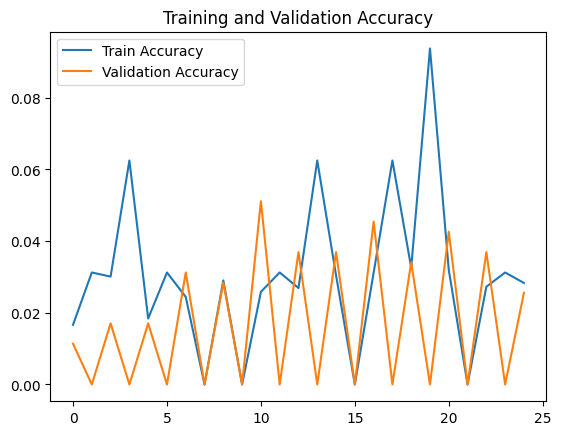

In [20]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

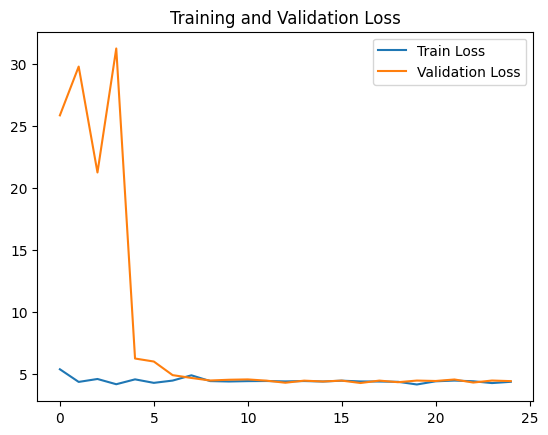

In [21]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.0451 - loss: 4.4229
Test Loss: 4.441400527954102
Test Accuracy: 0.024793388321995735


In [23]:
# Get the classification report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred))

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         5
           9       0.01      1.00      0.03         5
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         4
          15       0.50      0.80      0.62         5
          16       0.00      0.00      0

c:\Users\DELL\Desktop\DL-Assignment-Y4S1\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\Desktop\DL-Assignment-Y4S1\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\Desktop\DL-Assignment-Y4S1\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita